In [ ]:
#| default_exp launcher_r

# LIBS

In [ ]:
#| hide
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [ ]:
#| export
import numba
import numpy as np
from rl_opts.robot_search import RobotSearch, run_robot_training_parallel
from numba import set_num_threads 
from tqdm import tqdm
import pathlib
import os
numba.get_num_threads()
import matplotlib.pyplot as plt

# FUNCTIONS

In [ ]:
def save_args_to_text_file(foldername, filename, **args):
    # Create directory if it does not exist yet
    if not os.path.exists(foldername):
        os.makedirs(foldername)
    
    # Construct the full file path
    file_path = os.path.join(foldername, filename)
    with open(filename, 'w+') as file:
        for key, value in args.items():
            file.write(f"{key}: {value}\n")

In [ ]:
def get_prob_action(action: int, #Index of the action
                    h_matrix: np.array #h matrix with shape (number agents, number actions, number states)
                   )-> np.array: #array containing the probability of the given action for all states, for all agents. Shape (number agents, number states)
    "Given the h_matrix and the action, it gives an array with the probability of the given action for each state"
    
    number_agents = np.shape(h_matrix)[0]
    number_states = np.shape(h_matrix)[2]
    
    prob_action = np.zeros([number_agents, number_states])
    
    for ag in range(number_agents):
        for s in range(number_states):
            prob_action[ag, s] = h_matrix[ag, action, s] / np.sum(h_matrix[ag,:,s])
    
    return prob_action
    

In [ ]:
def get_policies(h_matrix: np.array #h matrix with shape (number agents, number actions, number states)
                   )-> np.array: #array containing the probability of the given action for all states, for all agents. Shape (number agents, number states)
    "Given the h_matrix for all agents, it gives an array with the policies for all agents"
    
    number_agents = np.shape(h_matrix)[0]
    number_actions = np.shape(h_matrix)[1]
    number_states = np.shape(h_matrix)[2]
    
    policies = np.zeros([number_agents, number_states, number_actions])
    
    for ag in range(number_agents):
        for s in range(number_states):
            for a in range(number_actions):
                policies[ag, s, a] = h_matrix[ag, a, s] / np.sum(h_matrix[ag,:,s])
    
    return policies
    

# Single robot

## EXP_1

### Input parameters

In [ ]:
#| export

# Training spec
TIME_EP = 2000
EPISODES = 1000
N_AGENTS = 30 # If you keep it below you number of cores, it runs in a single "run". If not, it needs to do N_AGENTS/N_CORES runs

# Environment 
Nt = 100; L = 100; r = 1; tau = 3; agent_radius = 2; avg_vel = 1.04; std_vel = 0.67; avg_turn_angle = 0.64; std_turn_angle = 0.41;


# Agent
size_state_space = np.array([TIME_EP], dtype=np.int64)
gamma_damping = 0.00001
eta_glow_damping = 0.1
initial_prob_distr = (np.array([0.988, 0.012/2, 0.012/2])*np.ones((3, TIME_EP)).transpose()).transpose()


Save input arguments in a text file

In [ ]:
foldername_robot1 = 'C:/Users/andrea/Desktop/collective_foraging/results/single_robot/exp_1/'

In [ ]:
save_args_to_text_file(foldername_robot1, foldername_robot1 +'input_args.txt',
                       N_agents = N_AGENTS, time_ep = TIME_EP, episodes = EPISODES,
                       tau = tau, 
                       Nt = Nt, L = L, r = r, agent_radius = agent_radius, avg_vel = avg_vel, std_vel=std_vel, avg_turn_angle=avg_turn_angle, std_turn_angle=std_turn_angle,
                       gamma = gamma_damping, eta = eta_glow_damping, initial_prob_continue = initial_prob_distr[0,0])

### Run

Run the parallel agents and save their rewards and final h matrices:

In [ ]:
rewards, h_matrix = run_robot_training_parallel(episodes = int(EPISODES), 
                                                time_ep = int(TIME_EP), 
                                                N_agents = N_AGENTS, 
                                                Nt = Nt, L = L, r = r, tau = tau, agent_radius = agent_radius,
                                                avg_vel = avg_vel, std_vel=std_vel, avg_turn_angle=avg_turn_angle, std_turn_angle=std_turn_angle,
                                                size_state_space = size_state_space,
                                                num_actions = 3,
                                                gamma_damping = gamma_damping,
                                                eta_glow_damping = eta_glow_damping, 
                                                initial_prob_distr = initial_prob_distr)

# np.save(foldername_robot1+'rewards.npy', rewards)
# np.save(foldername_robot1+'h_matrices.npy', h_matrix)

### Plot rewards

Text(0, 0.5, 'Average reward')

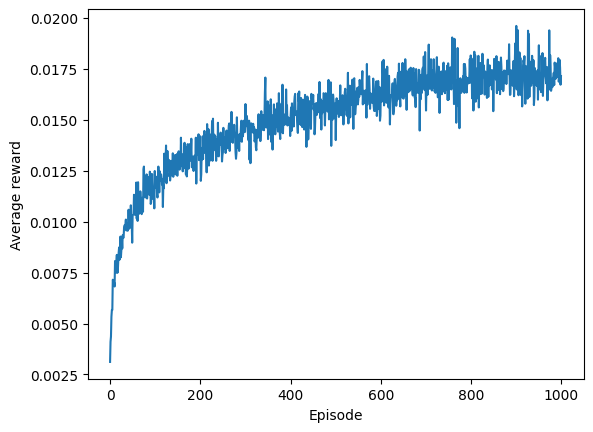

In [ ]:
plt.plot(np.mean(rewards, axis=0))
plt.xlabel('Episode'); plt.ylabel('Average reward')

Experiments with robots cannot do such long training times, so we need to optimize the number of RL steps and see when we start to see a difference in performance. It seems that only with 100 episodes and 2 agents, one sees a difference in performance between the beginning and the end of the learning, so we can show that they have learned something.

Text(0, 0.5, 'Average reward')

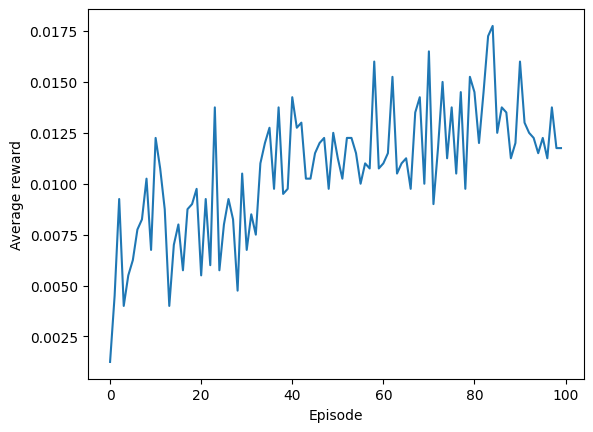

In [ ]:
plt.plot(np.mean(rewards[:2,:100], axis=0))
plt.xlabel('Episode'); plt.ylabel('Average reward')

Text(0, 0.5, 'Average reward last 100 episodes')

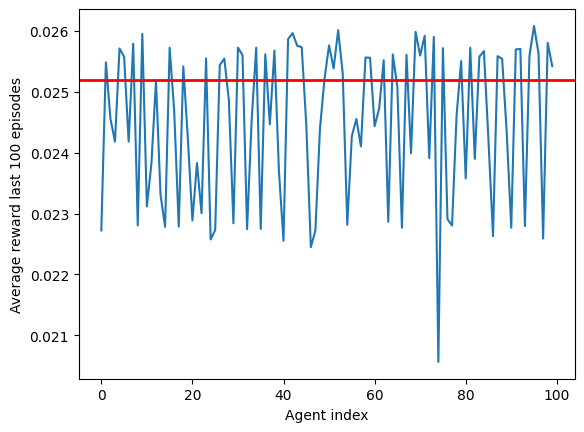

In [ ]:
R_th = 0.0252
plt.plot(np.mean(rewards[:,-100:20000],axis=1))
plt.axhline(y=R_th, color='red', linestyle='-', linewidth=2)
plt.xlabel('Agent index'); plt.ylabel('Average reward last 100 episodes')

### Plot policies

In [ ]:
np.shape(h_matrix)

(100, 3, 20000)

Action continue (0)

In [ ]:
prob_continue = get_prob_action(0, h_matrix)

Text(0.5, 1.0, 'Average prob continue over all (100) agents')

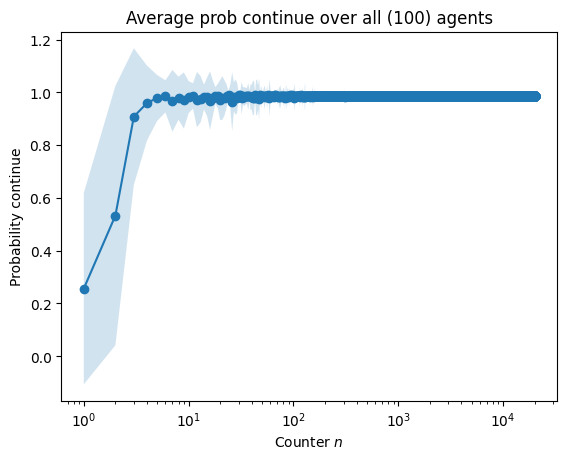

In [ ]:
#initial probability
#plt.plot(np.arange(1, np.shape(h_matrix)[2]+1), initial_prob_distr[0], 'k', '--')

#policy continue
x = np.arange(1, np.shape(h_matrix)[2]+1)
y = np.mean(prob_continue,axis=0)
error = np.std(prob_continue, axis=0)

#plot
plt.plot(x, y,'o-'); plt.fill_between(x, y-error, y+error, alpha=0.2)
#axis
plt.xscale('log'); plt.xlabel('Counter $n$')
plt.ylabel('Probability continue'); #plt.yticks(np.arange(0, 1.1, 0.2), np.arange(0, 1.1, 0.2))
plt.title('Average prob continue over all (100) agents')

Text(0.5, 1.0, 'Prob. continue for each agent')

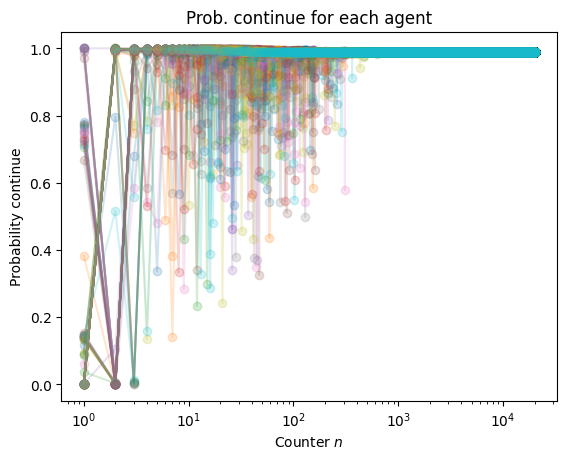

In [ ]:
#initial probability
#plt.plot(np.arange(1, np.shape(h_matrix)[2]+1), initial_prob_distr[0], 'k', '--')

#policy continue
x = np.arange(1, np.shape(h_matrix)[2]+1)

#plot
for a in range(np.shape(h_matrix)[0]):
    plt.plot(x, prob_continue[a,:],'o-', alpha=0.2)
#axis
plt.xscale('log'); plt.xlabel('Counter $n$')
plt.ylabel('Probability continue'); #plt.yticks(np.arange(0, 1.1, 0.2), np.arange(0, 1.1, 0.2))
plt.title('Prob. continue for each agent')

These agents: actions are "continue", "left" and "right". These last two actions are reorientations to the left or to the right with an angle sampled from a normal distribution. Reorientations have an offset radius and no extra displacement.

Ideal agents: "left", "right" and "back" actions are sampled from a uniform distr. over a region of 120 degrees. No offset radius and extra displacement of the same length as the action "continue".

Differences w.r.t ideal agents with actions "left, right, back":
- Agents turn with higher probabilities at intermediate counter values ($n>3$), which was not the case for ideal agents. Since these agents' turns are noisier, possibly the policies are also noisier and they learn to turn more.
- There are three populations: the ones that turn at $n=1$ and then they have high prob of continue for larger counters, the ones that turn at $n=2$ and then have high prob of continue for larger counters, and the ones that turn at both $n=1$ and $n=2$.

#### Separation of populations according to policies

<matplotlib.legend.Legend>

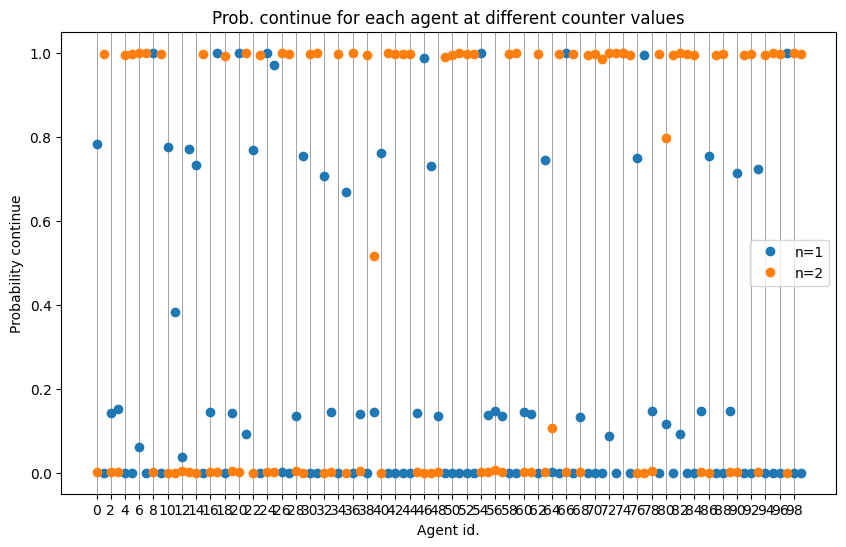

In [ ]:

plt.figure(figsize=(10, 6))

plt.plot(prob_continue[:,0],'o', label='n=1')
plt.plot(prob_continue[:,1], 'o', label='n=2')
#plt.plot(prob_continue[:,2], 'o', label='n=3')

plt.xticks(np.arange(0, 100, 2))

plt.grid(True, which='both', axis='x', linestyle='-', linewidth=0.5, color='grey')

# Set the labels and title
plt.xlabel('Agent id.')
plt.ylabel('Probability continue')
plt.title('Prob. continue for each agent at different counter values')

# Add a legend
plt.legend()


There are three populations: 

(i) agents that learn to turn at n=1 and then continue (blue points down and orange up)

(ii) agents that learn to turn at n=2 and then continue (blue points at 0.8 or 1 and orange down)

(iii) agents that learn to turn at n=1 and n=2 and then continue (blue points ar around 0.15 and orange down)

Separation of the populations based on the criteria above:

In [ ]:
pop_1 = np.where(prob_continue[:,0] < 0.02)
pop_2 = np.where(prob_continue[:,0] > 0.6)
pop_3 = np.where((prob_continue[:,0] > 0.03) & (prob_continue[:,0] < 0.2))

In [ ]:
pop_3

(array([ 2,  3,  6, 12, 16, 19, 21, 28, 33, 37, 39, 45, 48, 55, 56, 57, 60,
        61, 68, 72, 78, 80, 82, 85, 89], dtype=int64),)

Number of agents in population 1

In [ ]:
len(pop_1[0])

48

Number of agents in population 2

In [ ]:
len(pop_2[0])

26

Number of agents in population 3

In [ ]:
len(pop_3[0])

25

Total:

In [ ]:
len(pop_1[0])+len(pop_2[0])+len(pop_3[0])

99

**Agent 11 is not in any of the populations because its prob of continuing is 0.4 for n=1 and 0 for n=2.

Text(50, 0.1, 'Reward = 0.024')

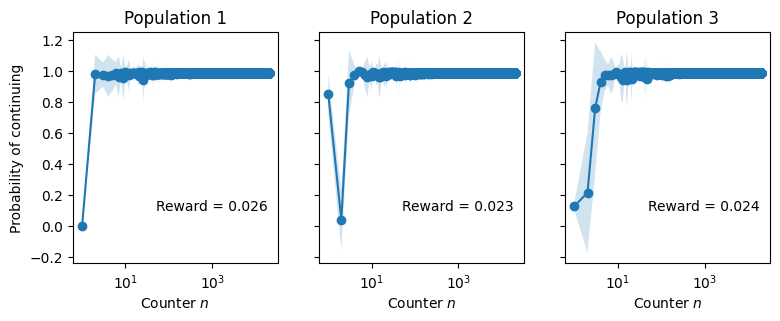

In [ ]:
#initial probability
#plt.plot(np.arange(1, np.shape(h_matrix)[2]+1), initial_prob_distr[0], 'k', '--')

#policy continue
x = np.arange(1, np.shape(h_matrix)[2]+1)
y1 = np.mean(prob_continue[pop_1,:][0],axis=0)
y2 = np.mean(prob_continue[pop_2,:][0],axis=0)
y3 = np.mean(prob_continue[pop_3,:][0],axis=0)
error1 = np.std(prob_continue[pop_1,:][0], axis=0)
error2 = np.std(prob_continue[pop_2,:][0], axis=0)
error3 = np.std(prob_continue[pop_3,:][0], axis=0)

fig, axs = plt.subplots(1, 3, figsize=(9, 3), sharey=True)
axs[0].plot(x, y1,'o-'); axs[0].fill_between(x, y1-error1, y1+error1, alpha=0.2)
axs[1].plot(x, y2,'o-'); axs[1].fill_between(x, y2-error2, y2+error2, alpha=0.2)
axs[2].plot(x, y3,'o-'); axs[2].fill_between(x, y3-error3, y3+error3, alpha=0.2)

axs[0].set_title('Population 1'); axs[1].set_title('Population 2'); axs[2].set_title('Population 3')
axs[0].set_ylabel('Probability of continuing')
for ax in axs:
    ax.set_xscale('log'); ax.set_xlabel('Counter $n$')

axs[0].text(50, 0.1,'Reward = '+str(np.round(np.mean(rewards[pop_1, -100:]),3)))
axs[1].text(50, 0.1,'Reward = '+str(np.round(np.mean(rewards[pop_2, -100:]),3)))
axs[2].text(50, 0.1,'Reward = '+str(np.round(np.mean(rewards[pop_3, -100:]),3)))

Text(0.5, 1.0, 'Prob. continue for each agent in Population 1')

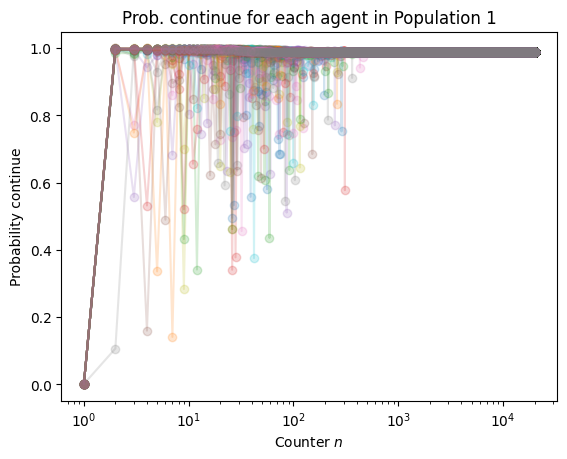

In [ ]:

#policy continue
x = np.arange(1, np.shape(h_matrix)[2]+1)

#plot
for a in pop_1[0]:
    plt.plot(x, prob_continue[a,:],'o-', alpha=0.2)
#axis
plt.xscale('log'); plt.xlabel('Counter $n$')
plt.ylabel('Probability continue'); #plt.yticks(np.arange(0, 1.1, 0.2), np.arange(0, 1.1, 0.2))
plt.title('Prob. continue for each agent in Population 1')

#### Separation of populations according to reward

Separation of populations based on reward. Threshold in R_th (defined above).

In [ ]:
pop_highR = np.where(np.mean(rewards[:,-100:],axis=1) > R_th)
pop_lowR = np.where(np.mean(rewards[:,-100:],axis=1) < R_th)

Text(100, 0.1, 'Reward = 0.024')

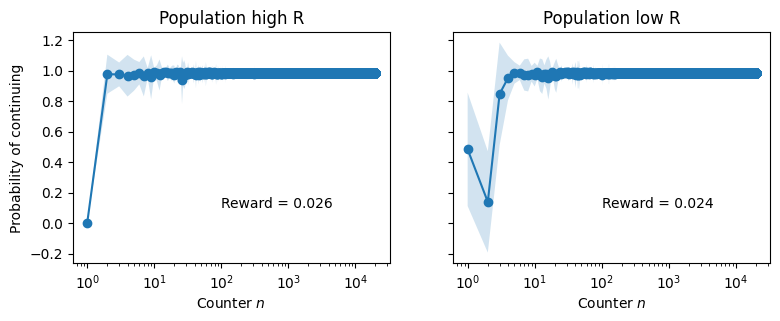

In [ ]:
#initial probability
#plt.plot(np.arange(1, np.shape(h_matrix)[2]+1), initial_prob_distr[0], 'k', '--')

#policy continue
x = np.arange(1, np.shape(h_matrix)[2]+1)
y1 = np.mean(prob_continue[pop_highR,:][0],axis=0)
y2 = np.mean(prob_continue[pop_lowR,:][0],axis=0)
error1 = np.std(prob_continue[pop_highR,:][0], axis=0)
error2 = np.std(prob_continue[pop_lowR,:][0], axis=0)

fig, axs = plt.subplots(1, 2, figsize=(9, 3), sharey=True)
axs[0].plot(x, y1,'o-'); axs[0].fill_between(x, y1-error1, y1+error1, alpha=0.2)
axs[1].plot(x, y2,'o-'); axs[1].fill_between(x, y2-error2, y2+error2, alpha=0.2)

axs[0].set_title('Population high R'); axs[1].set_title('Population low R')
axs[0].set_ylabel('Probability of continuing')
for ax in axs:
    ax.set_xscale('log'); ax.set_xlabel('Counter $n$')

axs[0].text(100, 0.1,'Reward = '+str(np.round(np.mean(rewards[pop_highR, -100:]),3)))
axs[1].text(100, 0.1,'Reward = '+str(np.round(np.mean(rewards[pop_lowR, -100:]),3)))

In [ ]:
pop_1

(array([ 1,  4,  5,  7,  9, 15, 18, 23, 26, 27, 30, 31, 34, 36, 38, 41, 42,
        43, 44, 49, 50, 51, 52, 53, 58, 59, 62, 64, 65, 67, 69, 70, 71, 73,
        75, 79, 81, 83, 84, 87, 88, 91, 92, 94, 95, 96, 98, 99],
       dtype=int64),)

In [ ]:
pop_highR

(array([ 1,  4,  5,  7,  9, 15, 18, 23, 26, 27, 30, 31, 34, 36, 38, 41, 42,
        43, 44, 49, 50, 51, 52, 53, 58, 59, 62, 64, 67, 69, 70, 71, 73, 75,
        79, 81, 83, 84, 87, 88, 91, 92, 94, 95, 96, 98, 99], dtype=int64),)

Essentially, the agents in population 1 are the ones achieving the highest reward. Agent 65 is in pop 1 but not in pop high R but it still achieves a high performance (around the R_th value).

#### Policy of best population

As we saw above, the agents achieving the best performance are the ones in population 1, i.e. the ones that learned to turn at $n=1$ and then continue (some also turn with some probability at intermediate counter values).

Action left (1), right (2)

In [ ]:
prob_left = get_prob_action(1, h_matrix)
prob_right = get_prob_action(2, h_matrix)

Policy with all actions plotted for population 1

[None,
 Text(0.5, 0, 'Counter $n$'),
 -0.1,
 1.05,
 None,
 Text(0.5, 0, 'Counter $n$'),
 -0.1,
 1.05,
 None,
 Text(0.5, 0, 'Counter $n$'),
 -0.1,
 1.05]

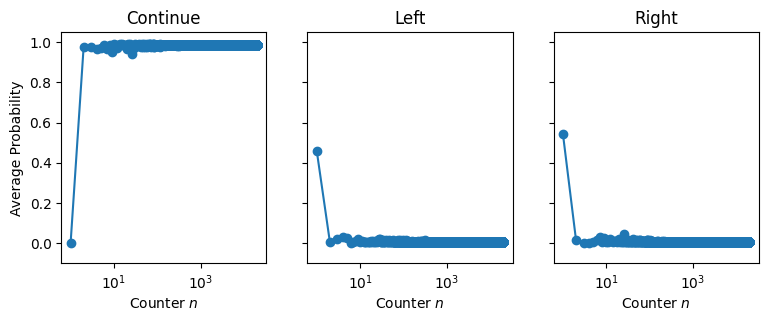

In [ ]:
fig, axs = plt.subplots(1, 3, figsize=(9, 3), sharey=True)
axs[0].plot(x, np.mean(prob_continue[pop_1,:][0],axis=0),'o-')
axs[1].plot(x, np.mean(prob_left[pop_1,:][0],axis=0),'o-')
axs[2].plot(x, np.mean(prob_right[pop_1,:][0],axis=0),'o-')
#axis
axs[0].set_title('Continue'); axs[1].set_title('Left');axs[2].set_title('Right')
axs[0].set_ylabel('Average Probability')

plt.setp(axs, xscale = 'log', xlabel = 'Counter $n$', ylim = (-0.1,1.05))



Zoom in to the small values to see if, when they turn, the probability is equally distributed between left and right:

[None,
 Text(0.5, 0, 'Counter $n$'),
 1.5,
 1000,
 -0.01,
 0.05,
 None,
 Text(0.5, 0, 'Counter $n$'),
 1.5,
 1000,
 -0.01,
 0.05,
 None,
 Text(0.5, 0, 'Counter $n$'),
 1.5,
 1000,
 -0.01,
 0.05]

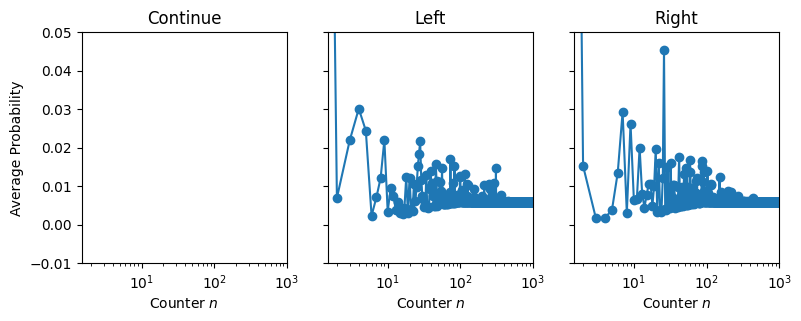

In [ ]:
fig, axs = plt.subplots(1, 3, figsize=(9, 3), sharey=True)
axs[0].plot(x, np.mean(prob_continue[pop_1,:][0],axis=0),'o-')
axs[1].plot(x, np.mean(prob_left[pop_1,:][0],axis=0),'o-')
axs[2].plot(x, np.mean(prob_right[pop_1,:][0],axis=0),'o-')
#axis
axs[0].set_title('Continue'); axs[1].set_title('Left');axs[2].set_title('Right')
axs[0].set_ylabel('Average Probability')

plt.setp(axs, xscale = 'log', xlabel = 'Counter $n$', xlim = (1.5,1000), ylim = (-0.01,0.05))



It seems it is in general pretty equal between left and right for most values of the counter. However, for $n=3,4,5$, there seems to be a tendency to turn more to the left than to the right, and for $n=25$ more to the right. Anyway, the action continue is in general far more probable for these counters.

In [ ]:
np.where(np.mean(prob_right[pop_1,:][0],axis=0)>0.04)

(array([ 0, 25], dtype=int64),)

Policy of a random agent within population 1

In [ ]:
agent_id = 58

[None,
 Text(0.5, 0, 'Counter $n$'),
 -0.1,
 1.05,
 None,
 Text(0.5, 0, 'Counter $n$'),
 -0.1,
 1.05,
 None,
 Text(0.5, 0, 'Counter $n$'),
 -0.1,
 1.05]

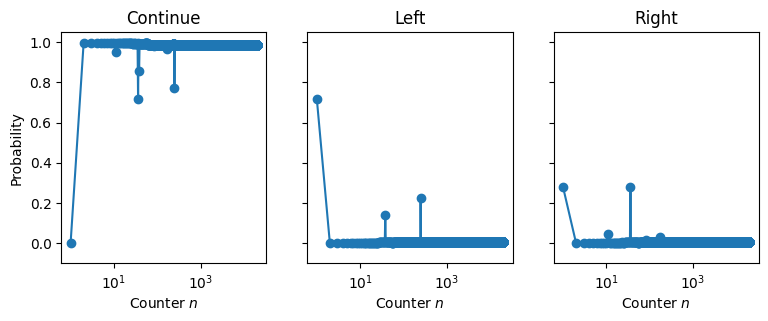

In [ ]:
fig, axs = plt.subplots(1, 3, figsize=(9, 3), sharey=True)
axs[0].plot(x, prob_continue[agent_id,:],'o-')
axs[1].plot(x, prob_left[agent_id,:],'o-')
axs[2].plot(x, prob_right[agent_id,:],'o-')
#axis
axs[0].set_title('Continue'); axs[1].set_title('Left');axs[2].set_title('Right')
axs[0].set_ylabel('Probability')

plt.setp(axs, xscale = 'log', xlabel = 'Counter $n$', ylim = (-0.1,1.05))


In [ ]:
np.where(prob_right[agent_id,:]>0.05)

(array([ 0, 35], dtype=int64),)

Important!! When they turn at $n=1$, agents have a preference to turn to one side all the time (which increases the probability to return to the same target again). If the agent would have learned to turn with equal prob. to both sides, it would get away from the target. In the following histogram, we see that, within population 1, some agents learn to turn left with high probability at $n=1$ and some learn to turn right at $n=1$ with high probability.

[Text(0.5, 0, 'Probability'), Text(0.5, 0, 'Probability')]

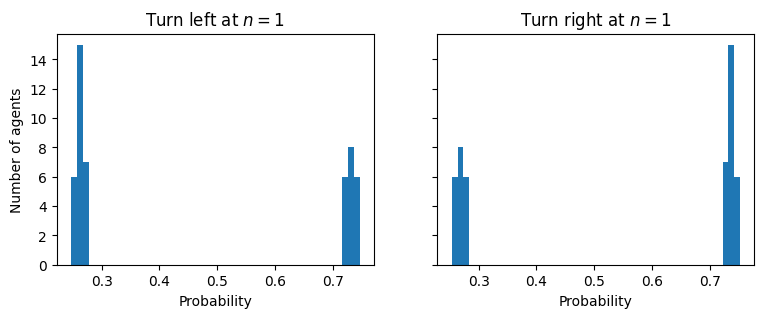

In [ ]:
fig, axs = plt.subplots(1, 2, figsize=(9, 3), sharey=True)

axs[0].hist(prob_left[pop_1[0],0],bins=50)
axs[1].hist(prob_right[pop_1[0],0],bins=50)

#axis
axs[0].set_title('Turn left at $n=1$'); axs[1].set_title('Turn right at $n=1$')
axs[0].set_ylabel('Number of agents')

plt.setp(axs, xlabel = 'Probability')

### Analysis of the walk

The aim of this test is to check that trained (single) agents with the new actions actually learn to come back to the same target and spend a lot of time around the target before changing to another one.

In [ ]:
#| export
import numba
import numpy as np
from rl_opts.robot_search import parallel_robots_trajectories

In [ ]:
policies = get_policies(h_matrix)

In [ ]:
number_visited_targets, agent_positions, target_positions, _ = parallel_robots_trajectories(time_ep = int(4e7),
                                                                                             N_agents = 100,
                                                                                             Nt = Nt,
                                                                                             L = L,
                                                                                             r = r,
                                                                                             tau = tau,
                                                                                             agent_radius = agent_radius,
                                                                                             avg_vel=avg_vel,
                                                                                             std_vel=std_vel,
                                                                                             avg_turn_angle=avg_turn_angle,
                                                                                             std_turn_angle=std_turn_angle,
                                                                                             policies = policies)
                                                                                             

np.save(foldername_robot1+'post_training_number_targets.npy', number_visited_targets)
np.save(foldername_robot1+'post_training_trajectories.npy', agent_positions)
np.save(foldername_robot1+'post_training_targets.npy', target_positions)

In [ ]:
np.shape(target_positions)

(100, 100, 2)

In [ ]:
np.save(foldername_robot1+'post_training_targets.npy', target_positions)

#### 1 agent output

We pick one agent of the pop 1 (high reward) and see policy, and analysis of the walk

In [ ]:
pop_1

(array([ 1,  4,  5,  7,  9, 15, 18, 23, 26, 27, 30, 31, 34, 36, 38, 41, 42,
        43, 44, 49, 50, 51, 52, 53, 58, 59, 62, 64, 65, 67, 69, 70, 71, 73,
        75, 79, 81, 83, 84, 87, 88, 91, 92, 94, 95, 96, 98, 99],
       dtype=int64),)

In [ ]:
agent_index = 50

Policy:

[None,
 Text(0.5, 0, 'Counter $n$'),
 Text(0, 0.5, 'Probability'),
 -0.1,
 1.1,
 None,
 Text(0.5, 0, 'Counter $n$'),
 Text(0, 0.5, 'Probability'),
 -0.1,
 1.1,
 None,
 Text(0.5, 0, 'Counter $n$'),
 Text(0, 0.5, 'Probability'),
 -0.1,
 1.1]

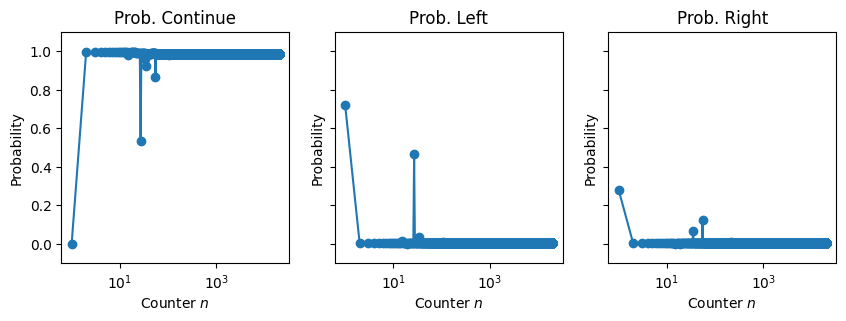

In [ ]:
fig_traj, ax_traj = plt.subplots(1, 3, figsize=(10, 3), sharey=True)
ax_traj[0].plot(x, prob_continue[agent_index,:],'o-')
ax_traj[1].plot(x, prob_left[agent_index,:],'o-')
ax_traj[2].plot(x, prob_right[agent_index,:],'o-')

ax_traj[0].set_title('Prob. Continue'); ax_traj[1].set_title('Prob. Left'); ax_traj[2].set_title('Prob. Right')

plt.setp(ax_traj, xscale = 'log', xlabel = 'Counter $n$', ylabel = 'Probability', ylim = (-0.1,1.1))

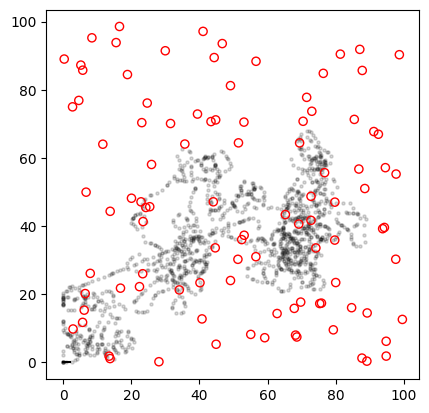

In [ ]:
fig_world, ax_world = plt.subplots()
plt.scatter(agent_positions[agent_index,:1500,0], agent_positions[agent_index,:1500,1], color='k', alpha=0.15, s=5)
plt.scatter(target_positions[agent_index,:,0], target_positions[agent_index,:,1], color = 'r', s=35, facecolors='none')
plt.plot([0,2],[0,0],'k')
ax_world.set_aspect('equal')


<matplotlib.colorbar.Colorbar>

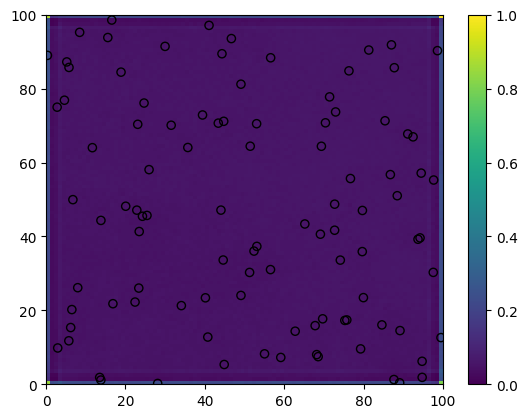

In [ ]:
plt.hist2d(agent_positions[agent_index,:,0], agent_positions[agent_index,:,1], bins=100, density=True)
plt.scatter(target_positions[agent_index,:,0], target_positions[agent_index,:,1], color = 'k', s=35, facecolors='none')
plt.colorbar()

They do not concentrate around the targets! (Probably because (i) they do not get reset to the center of the target when they find one and (ii) they have a noisier turn)

Same plot removing the boundaries (in the plot above, the boundaries accumulate density because the agent glides along them when it hits them).

<matplotlib.colorbar.Colorbar>

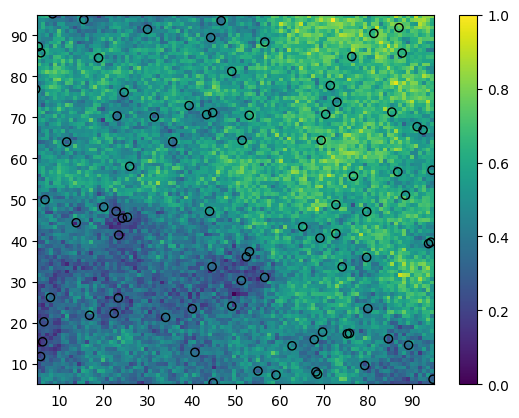

In [ ]:
# Filter positions that are within the 90x90 grid
max_L = 95
filtered_indices = (agent_positions[agent_index,:,0] >= L-max_L) * (agent_positions[agent_index,:,0] <= max_L) * (agent_positions[agent_index,:,1] >= L-max_L) * (agent_positions[agent_index,:,1] <= max_L)
filtered_pos_x = agent_positions[agent_index,:,0][filtered_indices]
filtered_pos_y = agent_positions[agent_index,:,1][filtered_indices]

# Plot the filtered positions
plt.hist2d(filtered_pos_x, filtered_pos_y, bins=100, density=True)
plt.scatter(target_positions[agent_index,:,0], target_positions[agent_index,:,1], color = 'k', s=35, facecolors='none')
plt.colorbar()

## EXP_2

### Input parameters

In [ ]:
#| export

# Training spec
TIME_EP = 1000000
EPISODES = 1
N_AGENTS = 100

# Environment 
Nt = 100; L = 100; r = 1; tau = 3; agent_radius = 2; avg_vel = 1.04; std_vel = 0.67; avg_turn_angle = 0.64; std_turn_angle = 0.41;


# Agent (we restrict the size of the h matrix to a maximum counter value of 10000)
size_state_space = np.array([10000], dtype=np.int64)
gamma_damping = 0.00001
eta_glow_damping = 0.1
initial_prob_distr = (np.array([0.988, 0.012/2, 0.012/2])*np.ones((3, 10000)).transpose()).transpose()

Save input arguments in a text file

In [ ]:
foldername_robot2 = 'C:/Users/andrea/Desktop/collective_foraging/results/single_robot/exp_2/'

In [ ]:
save_args_to_text_file(foldername_robot2, foldername_robot2 +'input_args.txt',
                       N_agents = N_AGENTS, time_ep = TIME_EP, episodes = EPISODES,
                       tau = tau, 
                       Nt = Nt, L = L, r = r, agent_radius = agent_radius, avg_vel = avg_vel, std_vel=std_vel, avg_turn_angle=avg_turn_angle, std_turn_angle=std_turn_angle,
                       gamma = gamma_damping, eta = eta_glow_damping, initial_prob_continue = initial_prob_distr[0,0])

### Run

Run the parallel agents and save their rewards and final h matrices:

In [ ]:
rewards2, h_matrix2 = run_robot_training_parallel(episodes = int(EPISODES), 
                                                time_ep = int(TIME_EP), 
                                                N_agents = N_AGENTS, 
                                                Nt = Nt, L = L, r = r, tau = tau, agent_radius = agent_radius,
                                                avg_vel = avg_vel, std_vel=std_vel, avg_turn_angle=avg_turn_angle, std_turn_angle=std_turn_angle,
                                                size_state_space = size_state_space,
                                                num_actions = 3,
                                                gamma_damping = gamma_damping,
                                                eta_glow_damping = eta_glow_damping, 
                                                initial_prob_distr = initial_prob_distr)

np.save(foldername_robot2+'h_matrices.npy', h_matrix2)

OSError: 100000000 requested and 0 written

In [ ]:
np.shape(rewards2)

(100, 1000000)

[<matplotlib.lines.Line2D>]

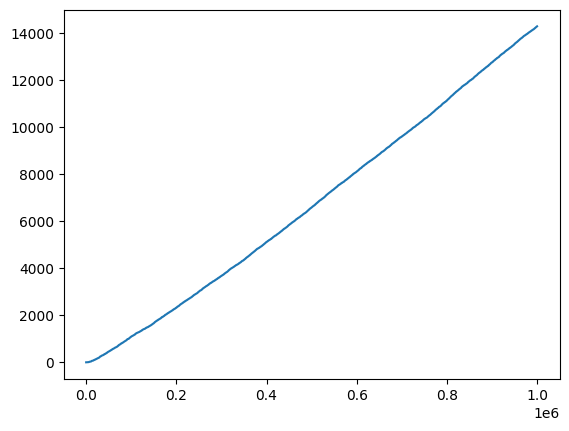

In [ ]:
plt.plot(np.cumsum(rewards2[0,:]))

In [ ]:
for i in range(20):
    np.save(foldername_robot2+'rewards_agent'+str(i)+'.npy', rewards2[i,:])

In [ ]:
type(rewards2)

numpy.ndarray

In [ ]:
rew = rewards2.astype(bool)

In [ ]:
rew

array([[False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       ...,
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False]])

In [ ]:
np.save(foldername_robot2+'rewards.npy', rew)

In [ ]:
np.shape(rew)

(100, 1000000)